# Overlap finemapped GWAS signals with ATAC-seq peaks and TFBS footprints
- only credible sets with <= 50 variants

In [2]:
setwd("/frazer01/projects/CARDIPS/analysis/cardiac_gwas_coloc")

source("script/functions.R"  )


In [3]:
dir.create("pipeline/6.2.footprints_finemap"                    , showWarnings = FALSE)
dir.create("pipeline/6.2.footprints_finemap/intersect_random"          , showWarnings = FALSE)
dir.create("pipeline/6.2.footprints_finemap/intersect_random/input"    , showWarnings = FALSE)
dir.create("pipeline/6.2.footprints_finemap/intersect_random/output"   , showWarnings = FALSE)
dir.create("pipeline/6.2.footprints_finemap/intersect_random/processed", showWarnings = FALSE)


In [4]:
loci             = add_rownames(fread  ("pipeline/1.2.genomewide_significant_loci/loci.txt"          , sep = "\t", header = TRUE, data.table = FALSE))
manifest         = add_rownames(fread  ("pipeline/1.1.sumstats/manifest.txt"                         , sep = "\t", header = TRUE, data.table = FALSE))
moloc_df         =              fread  ("pipeline/2.2.moloc/moloc.txt"                               , sep = "\t", header = TRUE, data.table = FALSE)
locus2coloc      =              fread  ("pipeline/5.4.analyze_coloc_qtl_som_maps/signal2coloc.txt"   , sep = "\t", header = TRUE, data.table = FALSE)
cs50             = locus2coloc[ locus2coloc$credible_set <= 50 & locus2coloc$finemapped == TRUE,]
meta_list        = lapply(cs50$id, function(id){readRDS(paste0("pipeline/5.5.meta_analysis/coloc_data/", id, ".rds"))})
names(meta_list) = cs50$id

In [5]:
random_vars_list = readRDS("pipeline/6.2.footprints_finemap/random/selected_by_variant.rds")

# TFBS motifs

In [6]:
motifs         = fread("/frazer01/projects/CARDIPS/analysis/footprint_eqtl/jaspar/exp_gene.txt", sep = "\t", header = TRUE, data.table = FALSE)
motifs$motif   = paste(motifs$base_id, motifs$version, sep = ".")
tfbs_folder    = "/frazer01/projects/CARDIPS/analysis/footprint_eqtl/bound_peak/motif"
tfbs           = fread("pipeline/6.2.footprints_finemap/tfbs.txt", sep = "\t", header = TRUE, data.table = FALSE)
rownames(tfbs) = tfbs$motif
tfbs$int       = sub("/intersect/", "/intersect_random/", tfbs$int)
tfbs$processed = sub("/intersect/", "/intersect_random/", tfbs$processed)


# Prepare BED file with fine mapped variants

In [7]:
cs_annot      = fread  ("pipeline/6.2.footprints_finemap/credible_sets_50_annotated.txt", sep = "\t", header = TRUE , data.table = FALSE)
credible_sets = fread  ("pipeline/6.2.footprints_finemap/intersect/credible_sets.txt"   , sep = "\t", header = TRUE , data.table = FALSE)
cs2motif_list = readRDS("pipeline/6.2.footprints_finemap/cs2motif_list.rds")


In [8]:
random_vars  = unique(unlist(random_vars_list))

chrom        = as.numeric(unlist(lapply(random_vars, function(x){unlist(strsplit(x, "_"))[[2]]})))
pos          = as.numeric(unlist(lapply(random_vars, function(x){unlist(strsplit(x, "_"))[[3]]})))
random_annot = data.frame(chrom = chrom, pos = pos, id = random_vars)

random_annot_bed = "pipeline/6.2.footprints_finemap/intersect_random/random_annot.bed"
random_annot     = random_annot[order(random_annot$chrom, random_annot$pos),]

fwrite(random_annot, "pipeline/6.2.footprints_finemap/intersect_random/random_annot.txt" , sep = "\t", col.names = TRUE , row.names = FALSE)
fwrite(random_annot[,c("chrom", "pos", "pos", "id")], random_annot_bed             , sep = "\t", col.names = FALSE, row.names = FALSE)


## Add consequence to credible set variants

In [9]:
snps       = fread(cmd = "zcat /frazer01/reference/public/ukbb/variants.tsv.bgz", sep = "\t", header = TRUE, data.table = FALSE)
snps       = snps[snps$chr %in% as.character(1:22),]
snps$chrom = as.numeric(snps$chr)
snps$id    = paste("VAR", snps$chrom, snps$pos, snps$ref, snps$alt, sep = "_")

In [10]:
random_annot_df = merge(random_annot, snps[,c("id", "rsid", "consequence", "consequence_category", "AF")], all.x = TRUE)

random_annot_df[ is.na(random_annot_df$consequence), "consequence_category"] = "non_coding"
random_annot_df[ is.na(random_annot_df$consequence), "consequence"         ] = "intergenic_variant"

fwrite(random_annot_df, "pipeline/6.2.footprints_finemap/random_annotated.txt", sep = "\t", col.names = TRUE, row.names = FALSE)

# Intersect random variants with motifs

In [11]:
intersect_credible_set = function(motif, tfbs, credible_sets_bed, credible_sets)
{
    bed_file   = tfbs[motif, "bed"      ]
    out_file   = tfbs[motif, "int"      ]
    processed  = tfbs[motif, "processed"]
    command    = paste("bedtools", "closest", "-d", "-t", "all", "-a", credible_sets_bed, "-b", bed_file, ">", out_file)
    
    return(command)
    
}
cs2motif_list_commands = unlist(lapply(tfbs$motif, function(motif){intersect_credible_set(motif, tfbs, random_annot_bed, random_annot)}))

writeLines(c(paste("cd", getwd()), cs2motif_list_commands), "script/commands.sh")

In [12]:
intersect_credible_set = function(motif, tfbs, credible_sets_bed, credible_sets)
{
    message(motif)
    bed_file   = tfbs[motif, "bed"      ]
    out_file   = tfbs[motif, "int"      ]
    processed  = tfbs[motif, "processed"]
    command    = paste("bedtools", "closest", "-d", "-t", "all", "-a", credible_sets_bed, "-b", bed_file, ">", out_file)
    
    #system(command)
    
    indata           = fread(out_file, sep = "\t", header = FALSE, data.table = FALSE)[,c(4,6:11)]
    colnames(indata) = c("id", "from", "to", "tfbs_coord", "peak", "tfbs_bound", "distance")
    indata           = merge(indata, credible_sets, by = c("id"))
    indata$motif     = motif
    out              = indata[,c("id", "chrom", "pos", "motif", "tfbs_coord", "peak", "tfbs_bound", "from", "to", "distance")]
    out$overlap      = 0
    out$distance100  = 0

    if(nrow(out[out$distance == 0,]) > 0)
    {
        out[out$distance == 0, "overlap"] = 1
    }
    if(nrow(out[out$distance <= 100,]) > 0)
    {
        out[out$distance <= 100, "distance100"] = 1
    }
    
    fwrite(out, processed, sep = "\t", col.names = TRUE, row.names = FALSE)
    
    return(out)
}

#cs2motif_list        = lapply(tfbs$motif, function(motif){intersect_credible_set(motif, tfbs, random_annot_bed, random_annot)})
#names(cs2motif_list) = tfbs$motif

#saveRDS(cs2motif_list, "pipeline/6.2.footprints_finemap/intersect_random/cs2motif_list.rds")


In [13]:
random_2motif_list        = lapply(tfbs$motif, function(motif){fread(tfbs[motif, "processed"], sep = "\t", header = TRUE, data.table = FALSE)})
names(random_2motif_list) = tfbs$motif


In [16]:
cs2motif_list = readRDS("pipeline/6.2.footprints_finemap/cs2motif_list.rds")


# Tests
- variants with high PPA are more likely to overlap active TFBS (bound in >20% samples)
- for each signal, is the variant with the highest PPA more likely to overlap an active TFBS?
- for each signal, is the variant with the highest PPA the closest to an active TFBS?
- how many signals have their credible set variants overlapping active TFBS?


## variants in credible sets are more likely to overlap or be close to TFBS
- YES, but this is not the right right way

In [39]:
enrichment_vs_all_random = function(motif, pp, mycol, cs2motif_list, random_2motif_list, random_vars_list)
{
    observed     = cs2motif_list     [[motif]]
    control      = random_2motif_list[[motif]]
    observed     = observed[observed$pp_snp >= pp,]
    control_vars = unique(unlist(random_vars_list[unique(observed$id)]))
    control      = control[control$id %in% control_vars,]
    out0         = data.frame(analysis = mycol, pp = pp, motif = motif)
    
    if(mycol == "distance")
    {
        totest = list(observed = observed[,mycol], control = control[,mycol])
        test   = t.test(totest[["observed"]], totest[["control"]])
        out    = data.frame(estimate_observed = test$estimate[[1]],
                            estimate_control  = test$estimate[[2]],
                            estimate          = test$estimate[[1]] - test$estimate[[2]],
                            ci1               = test$conf.int[[1]],
                            ci2               = test$conf.int[[2]],
                            pval              = test$p.value 
                           )
    }else
    {
        totest = matrix(c(nrow(observed [ observed [,mycol] == 1, ]),
                          nrow(observed [ observed [,mycol] == 0, ]),
                          nrow(control  [ control  [,mycol] == 1, ]),
                          nrow(control  [ control  [,mycol] == 0, ])
                         ), nrow = 2, byrow = TRUE)
        
        test   = fisher.test(totest)
        out    = data.frame(estimate_observed = nrow(observed [ observed [,mycol] == 1, ])/nrow(observed),
                            estimate_control  = nrow(control  [ control  [,mycol] == 1, ])/nrow(control ),
                            estimate          = test$estimate,
                            ci1               = test$conf.int[[1]],
                            ci2               = test$conf.int[[2]],
                            pval              = test$p.value 
                           )
        
    }
    return(cbind(out0, out))
}

#motif = "atac"
#pp    = 0.9
#mycol = "overlap"
#mycol = "distance"

tests_basic = as.data.frame(rbindlist(lapply(c("distance", "overlap", "distance100"), function(mycol)
{
    as.data.frame(rbindlist(lapply(c(0, 0.01, 0.05, 0.1, 0.2, 0.5, 0.9, 0.99), function(pp)
    {
        message(paste(mycol, pp))
        x = as.data.frame(rbindlist(lapply(tfbs$motif, function(motif)
        {
            enrichment_vs_all_random(motif, pp, mycol, cs2motif_list, random_2motif_list, random_vars_list)
        })), stringsAsFactors = FALSE)
        x$qval = p.adjust(x$pval, method = "BH")
        return(x)
    })), stringsAsFactors = FALSE)
})), stringsAsFactors = FALSE)

towrite = merge(tfbs[,c("motif", "name", "gene_name", "gene_id")], tests_basic)

fwrite(towrite, "pipeline/6.2.footprints_finemap/intersect_random/tests_basic.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


distance 0

distance 0.01

distance 0.05

distance 0.1

distance 0.2

distance 0.5

distance 0.9

distance 0.99

overlap 0

overlap 0.01

overlap 0.05

overlap 0.1

overlap 0.2

overlap 0.5

overlap 0.9

overlap 0.99

distance100 0

distance100 0.01

distance100 0.05

distance100 0.1

distance100 0.2

distance100 0.5

distance100 0.9

distance100 0.99



In [122]:
tfbs2n = tfbs[,c("motif", "name")]
tfbs2n$n = unlist(lapply(tfbs2n$motif, function(motif)
{
    x = cs2motif_list[[motif]]
    return(nrow(x[x$overlap == 1,]))
}))

In [128]:
tfbs2n[ tfbs2n$name == "NKX2-5",]
tfbs2n[ tfbs2n$name == "MEF2A" ,]

tfbs2n[ order(tfbs2n$n, decreasing = TRUE),]

,motif,name,n
,<chr>,<chr>,<int>
MA0063.2,MA0063.2,NKX2-5,1


,motif,name,n
,<chr>,<chr>,<int>
MA0052.4,MA0052.4,MEF2A,5


,motif,name,n
,<chr>,<chr>,<int>
atac,atac,ATAC,2052
MA1653.1,MA1653.1,ZNF148,36
MA1596.1,MA1596.1,ZNF460,27
MA0039.4,MA0039.4,KLF4,26
MA0162.4,MA0162.4,EGR1,21
MA0528.2,MA0528.2,ZNF263,21
MA1513.1,MA1513.1,KLF15,21
MA1107.2,MA1107.2,KLF9,20
MA0599.1,MA0599.1,KLF5,18


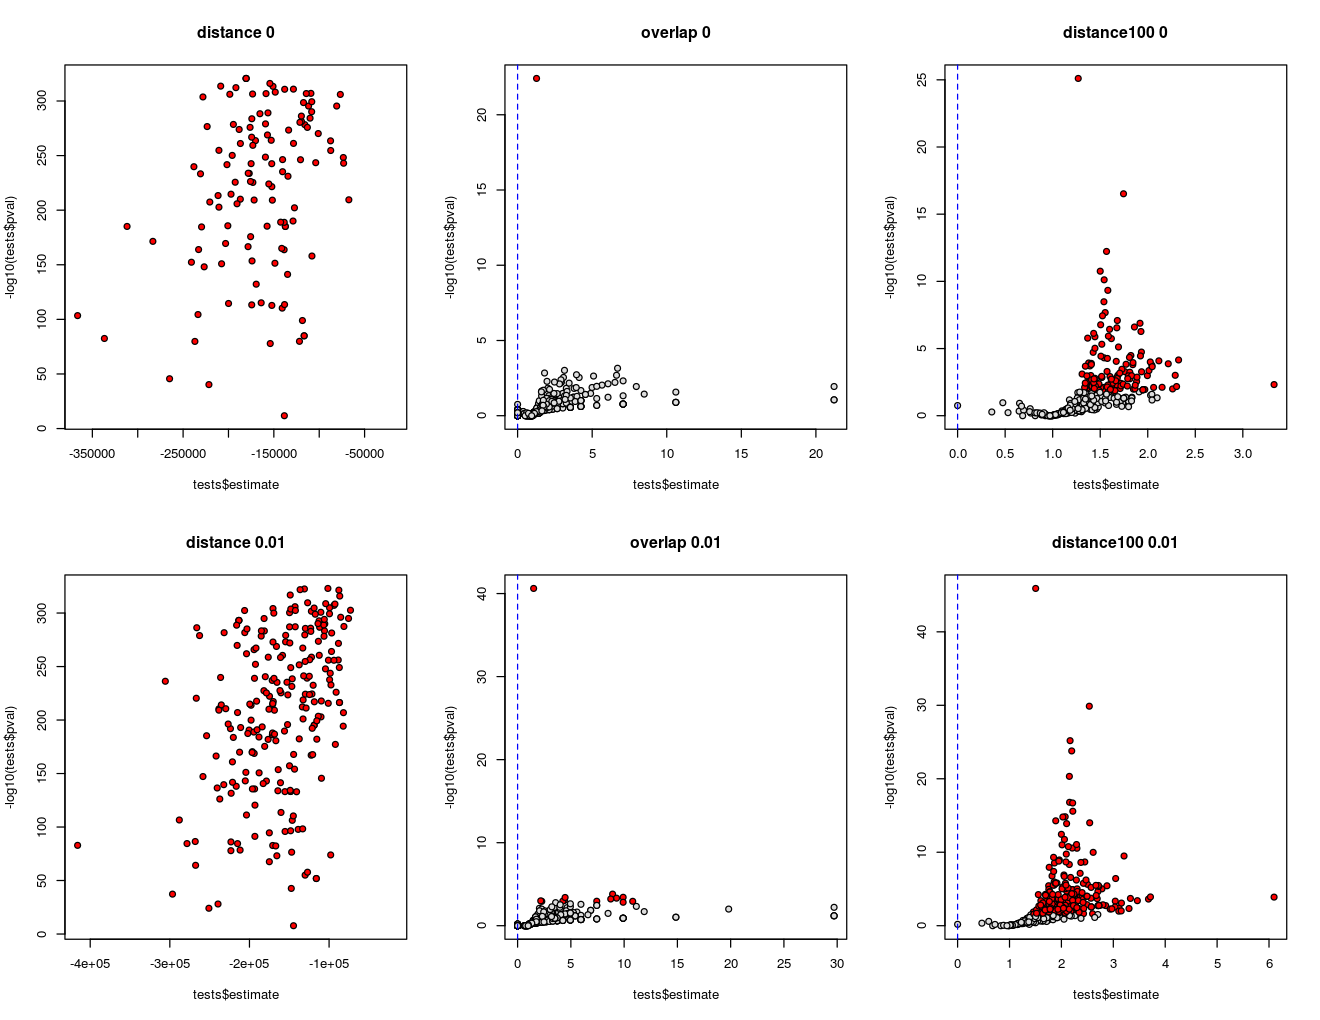

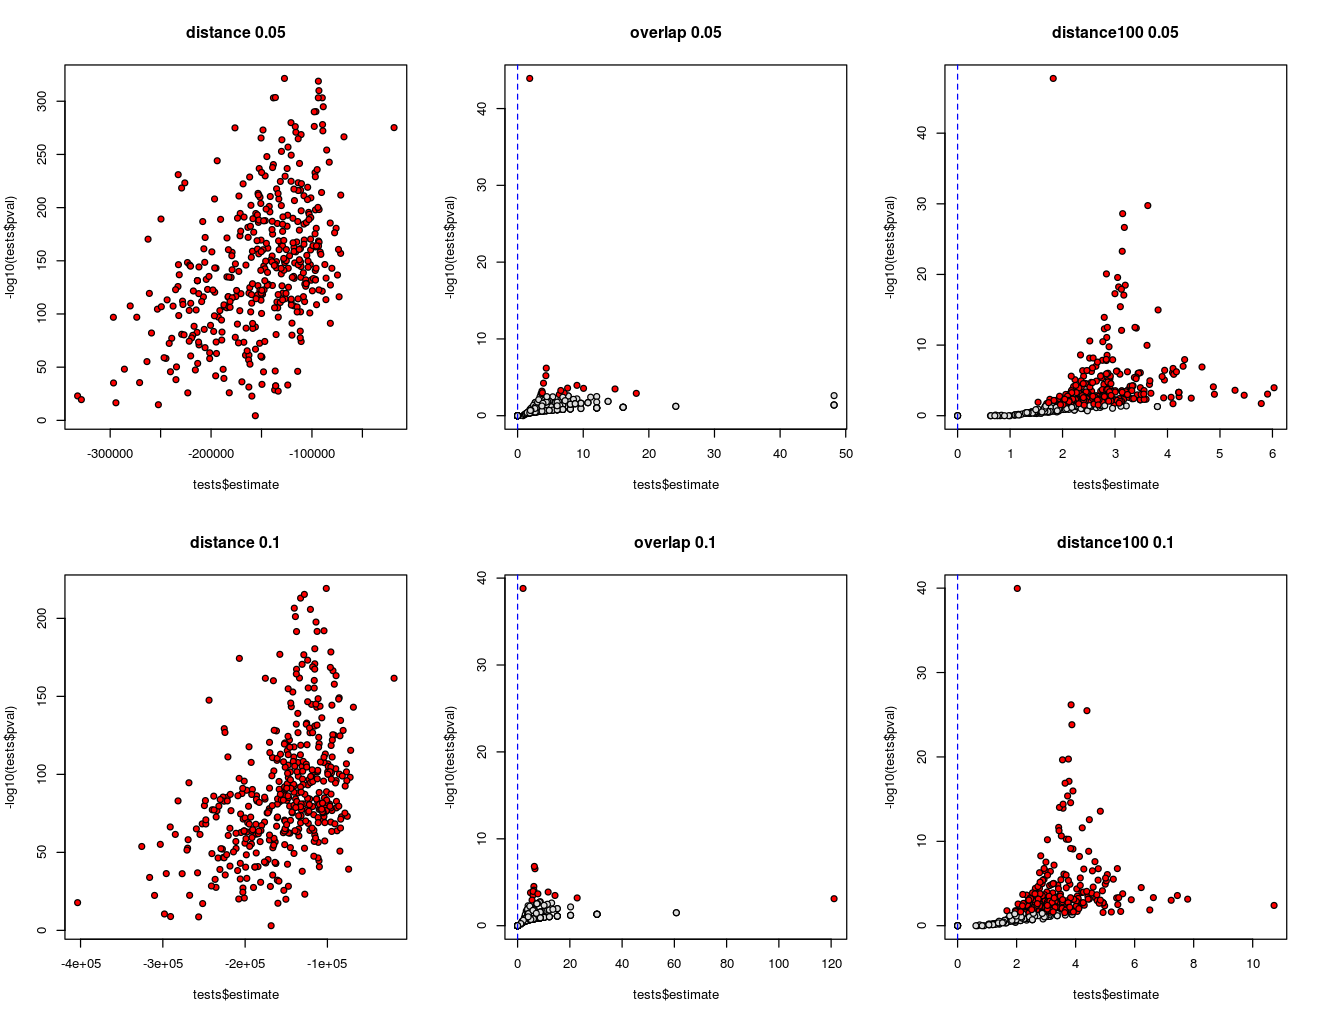

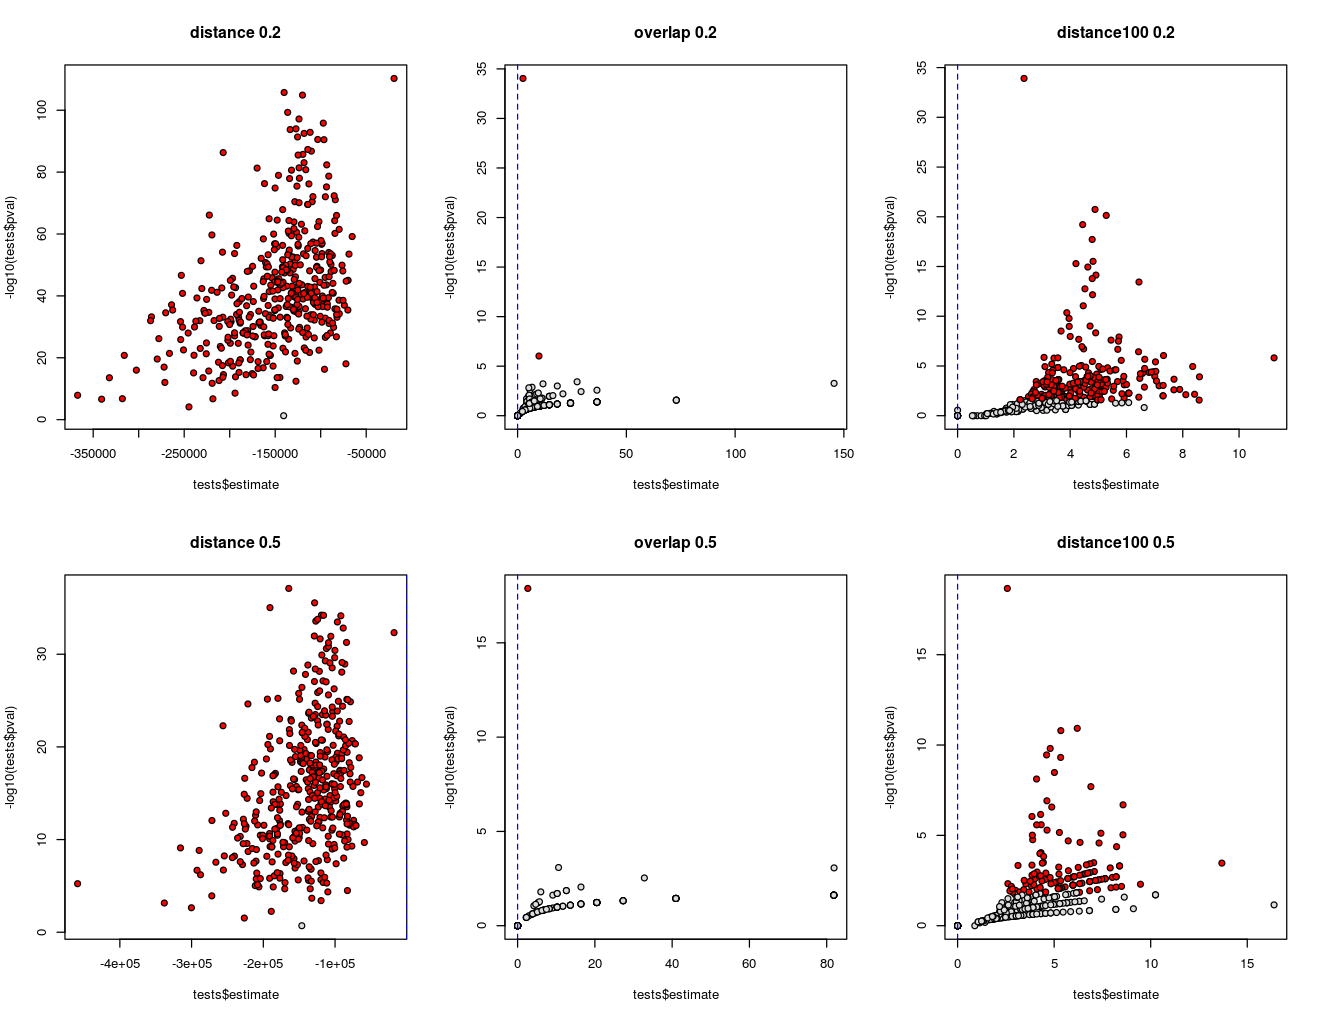

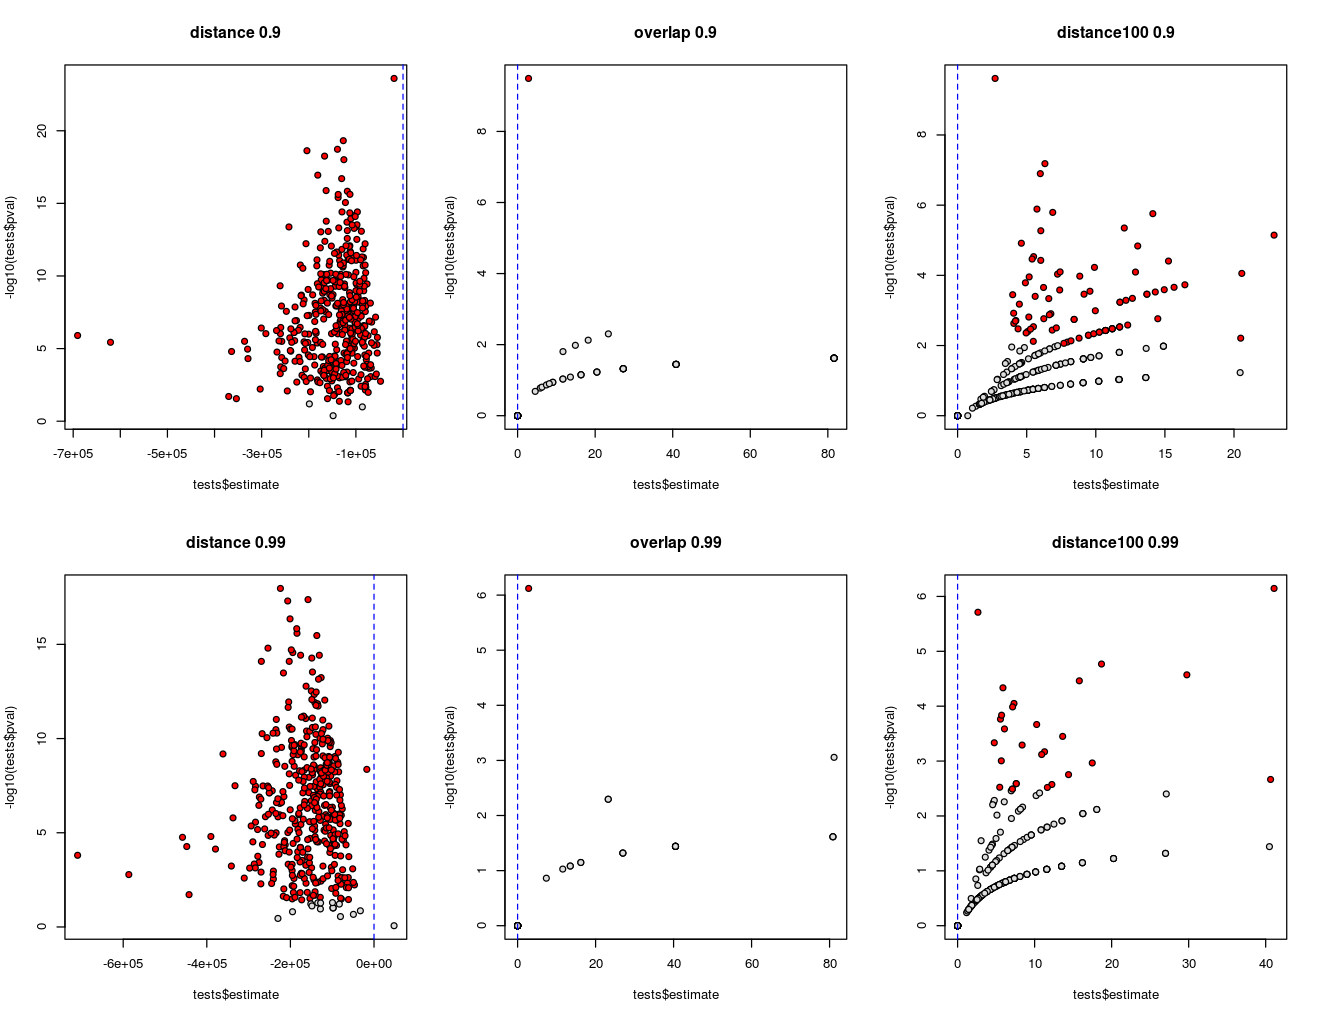

In [118]:
plot_tests = function(analysis, pp, tests)
{
    tests = tests[tests$analysis == analysis & tests$pp == pp,]
    
    if(nrow(tests[ is.na(tests$estimate) == TRUE | is.nan(tests$estimate) == TRUE, ]) > 0){tests[ is.na(tests$estimate) == TRUE | is.nan(tests$estimate) == TRUE, "estimate"] = 0}
    if(nrow(tests[ is.na(tests$pval    ) == TRUE | is.nan(tests$pval    ) == TRUE, ]) > 0){tests[ is.na(tests$pval    ) == TRUE | is.nan(tests$pval    ) == TRUE, "pval"    ] = 1}
    if(nrow(tests[ is.na(tests$qval    ) == TRUE | is.nan(tests$qval    ) == TRUE, ]) > 0){tests[ is.na(tests$qval    ) == TRUE | is.nan(tests$qval    ) == TRUE, "qval"    ] = 1}
    
    tests$color = "#dddddd"
    
    tests[ tests$qval <= 0.05, "color"] = "#ff0000"
    
    plot(tests$estimate, -log10(tests$pval), pch = 21, bg = tests$color, main = paste(analysis, pp))
    abline(v = 0, lty = "dashed", col = "#0000ff")
    
    #return(tests)
}

options(repr.plot.width = 11, repr.plot.height = 8.5)
layout(rbind(1:3, 4:6))


pp       = 0.99
analysis = "overlap"
#analysis = "distance"
tests    = merge(tfbs[,c("motif", "name", "gene_name", "gene_id")], tests_basic)

invisible(lapply(c(0, 0.01, 0.05, 0.1, 0.2, 0.5, 0.9, 0.99), function(pp)
{
    invisible(lapply(c("distance", "overlap", "distance100"), function(analysis)
    {
        plot_tests(analysis, pp, tests)
    }))
}))


In [115]:
str(tests)

'data.frame':	10296 obs. of  13 variables:
 $ motif            : chr  "atac" "atac" "atac" "atac" ...
 $ name             : chr  "ATAC" "ATAC" "ATAC" "ATAC" ...
 $ gene_name        : chr  "" "" "" "" ...
 $ gene_id          : chr  "" "" "" "" ...
 $ analysis         : chr  "overlap" "overlap" "distance" "distance100" ...
 $ pp               : num  0.2 0 0.99 0.2 0.05 0.99 0.1 0.5 0.01 0.5 ...
 $ estimate_observed: num  9.43e-02 5.54e-02 1.75e+04 1.03e-01 7.09e-02 ...
 $ estimate_control : num  4.05e-02 4.41e-02 3.48e+04 4.65e-02 3.97e-02 ...
 $ estimate         : num  2.47 1.27 -17224.63 2.36 1.84 ...
 $ ci1              : num  2.16 1.21 -22822.83 2.08 1.7 ...
 $ ci2              : num  2.81 1.33 -11626.43 2.67 2 ...
 $ pval             : num  9.22e-35 3.85e-23 4.32e-09 1.23e-34 1.20e-44 ...
 $ qval             : num  3.95e-32 1.65e-20 1.57e-08 5.28e-32 5.15e-42 ...


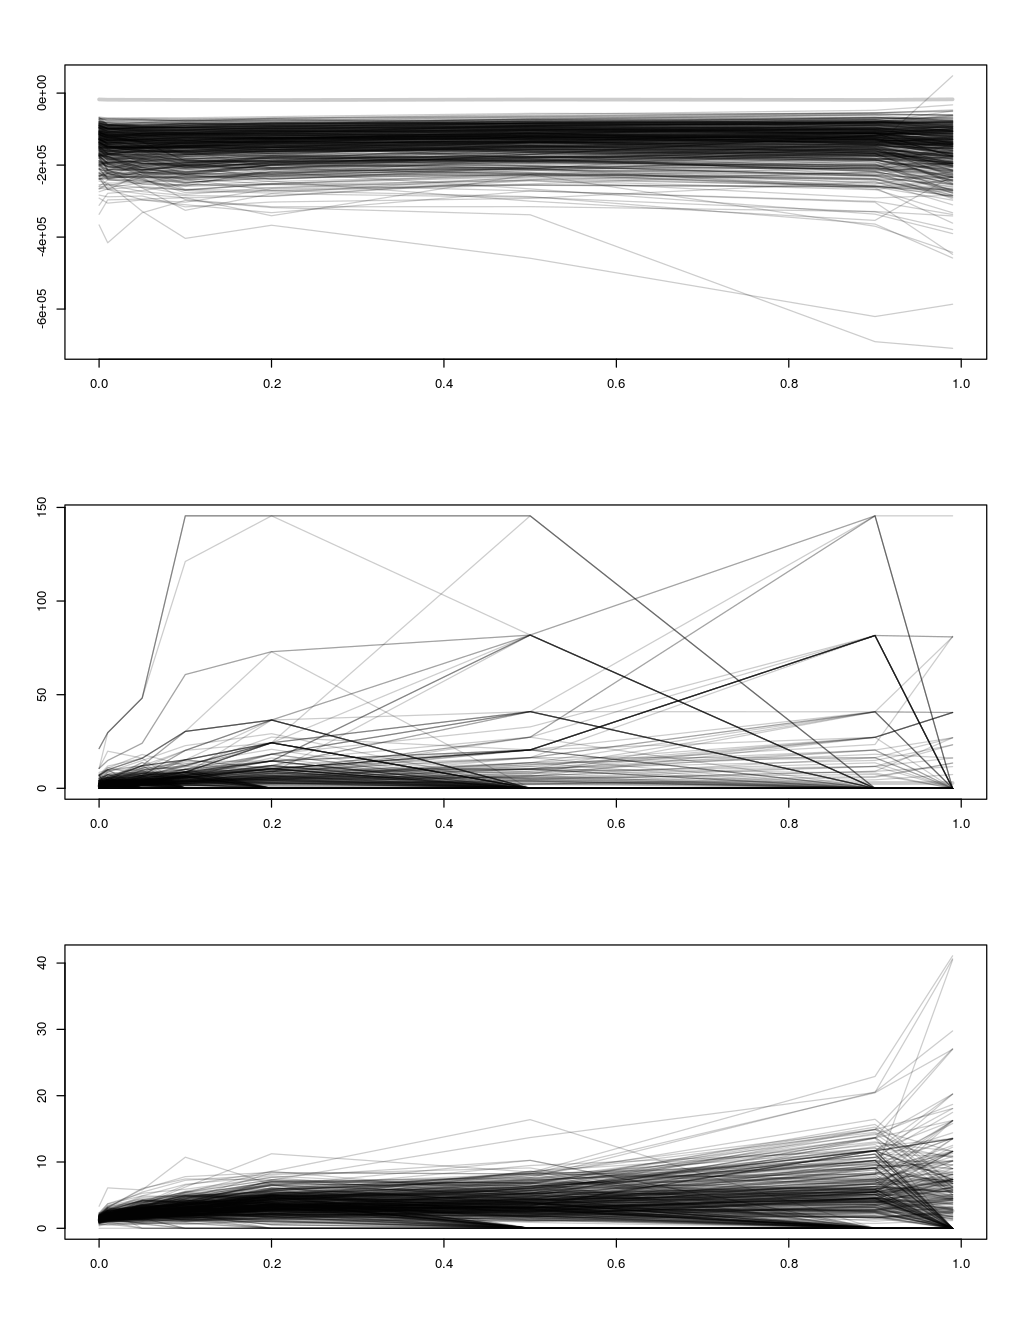

In [57]:
plot_associations = function(analysis, tests)
{
    indata = tests[tests$analysis == analysis,]
    
    if(nrow(indata[ is.infinite(indata$estimate) == TRUE & indata$estimate < 0, ]) > 0){indata[ is.infinite(indata$estimate) == TRUE & indata$estimate < 0, "estimate"] = min(indata[ is.infinite(indata$estimate) == FALSE & indata$estimate < 0, "estimate"])}
    if(nrow(indata[ is.infinite(indata$estimate) == TRUE & indata$estimate > 0, ]) > 0){indata[ is.infinite(indata$estimate) == TRUE & indata$estimate > 0, "estimate"] = max(indata[ is.infinite(indata$estimate) == FALSE & indata$estimate > 0, "estimate"])}
    
    pps    = sort(unique(indata$pp))
    xlims  = range(pps)
    ylims  = range(indata$estimate)
    
    plot(1,1, type = "n", xlim = xlims, ylim = ylims, xlab = "", ylab = "")
    
    for(motif in sort(unique(indata$motif)))
    {
        lwd = 1
        
        if(motif == "atac"){lwd = 3}
        
        toplot = indata[indata$motif == motif,]
        lines(x = toplot$pp, toplot$estimate, lwd = lwd, col = "#00000033")
    }
}

analysis = "distance"

options(repr.plot.width = 8.5, repr.plot.height = 11)
layout(cbind(1:3))

invisible(lapply(c("distance", "overlap", "distance100"), function(analysis){plot_associations(analysis, tests_basic)}))


## variants in credible sets are more likely to overlap or be close to TFBS: compare against 100 random sets
- ?

In [86]:
calculate_by_perm = function(perm, mycol, control_var_list, control)
{
    control_vars = unique(unlist(lapply(control_var_list, function(x){x[[perm]]})))
    control      = control[control$id %in% control_vars,]
    
    return(mean(control[control[,mycol] < 1000000, mycol]))
}

enrichment_vs_perm = function(motif, pp, mycol, cs2motif_list, random_2motif_list, random_vars_list, perms = 100)
{
    observed         = cs2motif_list     [[motif]]
    control          = random_2motif_list[[motif]]
    observed         = observed[observed$pp_snp >= pp,]
    control_var_list = random_vars_list[unique(observed$id)]
    mymean           = mean(observed[observed[,mycol] < 1000000, mycol])
    controls         = unlist(lapply(1:perms, function(perm){calculate_by_perm(perm, mycol, control_var_list, control)}))
    controls_mean    = mean(controls)
    controls_sd      = sd  (controls)
    zscore           = (mymean - controls_mean) / controls_sd
    pval             = 2*pnorm(-abs(zscore))
    out              = data.frame(analysis      = mycol, 
                                  pp            = pp   , 
                                  motif         = motif,
                                  observed      = mymean,
                                  expected_mean = controls_mean,
                                  expected_sd   = controls_sd,
                                  zscore        = zscore,
                                  pval          = pval
                                 )
    
    return(out)
    
}

#motif = "atac"
#pp    = 0.9
#mycol = "overlap"
#mycol = "distance"
#
#x = enrichment_vs_perm(motif, pp, mycol, cs2motif_list, random_2motif_list, random_vars_list, 10)

tests_vs_perm = as.data.frame(rbindlist(lapply(c("distance", "overlap", "distance100"), function(mycol)
{
    #as.data.frame(rbindlist(lapply(c(0, 0.01, 0.05, 0.1, 0.2, 0.5, 0.9, 0.99), function(pp)
    as.data.frame(rbindlist(lapply(c(0.01, 0.99), function(pp)
    {
        x = as.data.frame(rbindlist(lapply(tfbs$motif, function(motif)
        {
            message(paste(mycol, pp, motif))
            enrichment_vs_perm(motif, pp, mycol, cs2motif_list, random_2motif_list, random_vars_list, 100)
        })), stringsAsFactors = FALSE)
        x$qval = p.adjust(x$pval, method = "BH")
        return(x)
    })), stringsAsFactors = FALSE)
})), stringsAsFactors = FALSE)

towrite = merge(tfbs[,c("motif", "name", "gene_name", "gene_id")], tests_vs_perm)

fwrite(towrite, "pipeline/6.2.footprints_finemap/intersect_random/tests_vs_perm.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


distance 0.01 MA0002.2

distance 0.01 MA0003.4

distance 0.01 MA0007.3

distance 0.01 MA0017.2

distance 0.01 MA0018.4

distance 0.01 MA0024.3

distance 0.01 MA0025.2

distance 0.01 MA0028.2

distance 0.01 MA0031.1

distance 0.01 MA0032.2

distance 0.01 MA0033.2

distance 0.01 MA0036.3

distance 0.01 MA0037.3

distance 0.01 MA0039.4

distance 0.01 MA0043.3

distance 0.01 MA0050.2

distance 0.01 MA0051.1

distance 0.01 MA0052.4

distance 0.01 MA0056.2

distance 0.01 MA0057.1

distance 0.01 MA0058.3

distance 0.01 MA0059.1

distance 0.01 MA0060.3

distance 0.01 MA0062.3

distance 0.01 MA0063.2

distance 0.01 MA0065.2

distance 0.01 MA0066.1

distance 0.01 MA0070.1

distance 0.01 MA0071.1

distance 0.01 MA0072.1

distance 0.01 MA0073.1

distance 0.01 MA0074.1

distance 0.01 MA0075.3

distance 0.01 MA0076.2

distance 0.01 MA0077.1

distance 0.01 MA0079.4

distance 0.01 MA0080.5

distance 0.01 MA0083.3

distance 0.01 MA0088.2

distance 0.01 MA0089.2

distance 0.01 MA0090.3

distance 0.01 MA

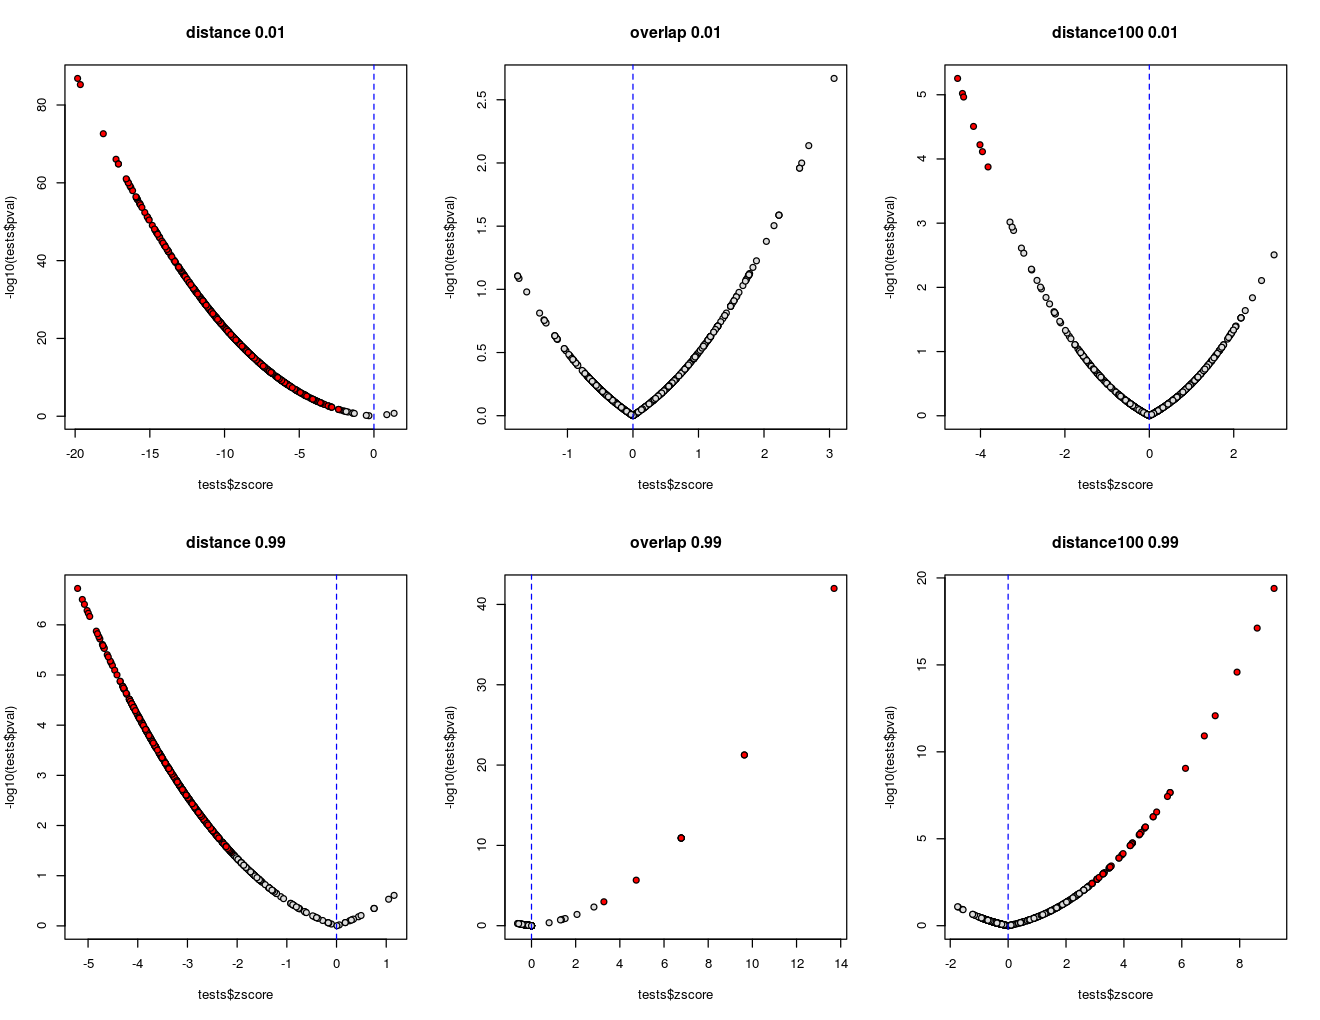

In [116]:
plot_tests = function(analysis, pp, tests)
{
    tests = tests[tests$analysis == analysis & tests$pp == pp,]
    
    if(nrow(tests[ is.na(tests$zscore) == TRUE | is.nan(tests$zscore) == TRUE, ]) > 0){tests[ is.na(tests$zscore) == TRUE | is.nan(tests$zscore) == TRUE, "zscore"] = 0}
    if(nrow(tests[ is.na(tests$pval  ) == TRUE | is.nan(tests$pval  ) == TRUE, ]) > 0){tests[ is.na(tests$pval  ) == TRUE | is.nan(tests$pval  ) == TRUE, "pval"  ] = 1}
    if(nrow(tests[ is.na(tests$qval  ) == TRUE | is.nan(tests$qval  ) == TRUE, ]) > 0){tests[ is.na(tests$qval  ) == TRUE | is.nan(tests$qval  ) == TRUE, "qval"  ] = 1}
    
    tests$color = "#dddddd"
    
    tests[ tests$qval <= 0.05, "color"] = "#ff0000"
    
    plot(tests$zscore, -log10(tests$pval), pch = 21, bg = tests$color, main = paste(analysis, pp))
    abline(v = 0, lty = "dashed", col = "#0000ff")
    
    #return(tests)
}

options(repr.plot.width = 11, repr.plot.height = 8.5)
layout(cbind(1:2, 3:4, 5:6))


pp       = 0.99
analysis = "overlap"
#analysis = "distance"
tests    = merge(tfbs[,c("motif", "name", "gene_name", "gene_id")], tests_vs_perm)

invisible(lapply(c("distance", "overlap", "distance100"), function(analysis)
{
    invisible(lapply(c(0.01, 0.99), function(pp)
    {
        plot_tests(analysis, pp, tests)
    }))
}))


In [90]:
str(tests)

'data.frame':	2574 obs. of  12 variables:
 $ motif        : chr  "atac" "atac" "atac" "atac" ...
 $ name         : chr  "ATAC" "ATAC" "ATAC" "ATAC" ...
 $ gene_name    : chr  "" "" "" "" ...
 $ gene_id      : chr  "" "" "" "" ...
 $ analysis     : chr  "distance100" "overlap" "overlap" "distance" ...
 $ pp           : num  0.01 0.99 0.01 0.01 0.99 0.99 0.01 0.01 0.99 0.99 ...
 $ observed     : num  6.96e-02 1.24e-01 6.08e-02 1.96e+04 1.75e+04 ...
 $ expected_mean: num  7.02e-02 8.70e-02 6.39e-02 3.42e+04 3.00e+04 ...
 $ expected_sd  : num  2.73e-03 1.29e-02 2.60e-03 1.01e+03 4.45e+03 ...
 $ zscore       : num  -0.21 2.83 -1.19 -14.5 -2.79 ...
 $ pval         : num  8.34e-01 4.70e-03 2.32e-01 1.22e-47 5.22e-03 ...
 $ qval         : num  9.87e-01 1.04e-01 9.96e-01 1.54e-46 9.65e-03 ...


In [77]:
1+1

[1] 2

# OLD

In [ ]:
test_pp = function(indata, x)
{
    indata$x = indata[,x]
    
    fit = as.data.frame(summary(lm(pp_snp ~ x, data = indata))$coefficients)
    
    if("x" %in% rownames(fit))
    {
        out = fit["x", c("Estimate", "Std. Error", "Pr(>|t|)")]
        colnames(out) = c("beta", "se", "pval")
    }else
    {
        out = data.frame(beta = 0, se = 1, pval = 1)
    }
    
    colnames(out) = paste(x, colnames(out), sep = ".")
    
    return(out)
}

test_binary = function(motif, tfbs, cs2motif_list)
{
    indata         = cs2motif_list[[motif]]
    out            = data.frame(motif = motif, overlap = nrow(indata[indata$overlap == 1,]), distance100 = nrow(indata[indata$distance100 == 1,]))
    out            = cbind(out, test_pp(indata                             , "overlap"    ))
    out            = cbind(out, test_pp(indata                             , "distance100"))
    out            = cbind(out, test_pp(indata[indata$distance <= 1000000,], "distance"   ))
    
    return(out)
}

test_overlap = as.data.frame(rbindlist(lapply(tfbs$motif, function(motif){test_binary(motif, tfbs, cs2motif_list)})), stringsAsFactors = FALSE)
test_overlap = merge(tfbs[,c("motif", "name", "gene_id", "gene_name")], test_overlap)

for (x in c("overlap", "distance100", "distance"))
{
    test_overlap[,paste(x, "qval", sep = ".")] = p.adjust(test_overlap[,paste(x, "pval", sep = ".")], method = "BH")
}

fwrite(test_overlap, "pipeline/6.2.footprints_finemap/intersect_random/test_overlap.txt", sep = "\t", col.names = TRUE, row.names = FALSE)

In [ ]:
plot_volcano = function(x, test_overlap)
{
    toplot   = test_overlap
    toplot$x =        toplot[,paste(x, "beta", sep = ".")]
    toplot$y = -log10(toplot[,paste(x, "pval", sep = ".")])
    toplot   = toplot[order(toplot$y),]
    
    toplot$color = "#ffffff"
    
    toplot[toplot[,paste(x, "qval", sep = ".")] <= 0.05, "color"] = "#ff0000"
    
    
    xlims    = max(abs(toplot$x))
    xlims    = c(-xlims, xlims)
    
    plot(1,1, type = "n", xlim = xlims, ylim = c(0, max(toplot$y)), xlab = "Effect size", ylab = "-log10(p)", main = x)
    
    abline(v = 0, lty = "dashed", col = "#0000ff")
    
    points(x = toplot$x, y = toplot$y, pch = 21, bg = toplot$color)
}

plot_volcano("overlap"    , test_overlap)
plot_volcano("distance100", test_overlap)
plot_volcano("distance"   , test_overlap)


In [ ]:
cs2motif_df = as.data.frame(rbindlist(cs2motif_list), stringsAsFactors = FALSE)
cs2motif_df = aggregate(distance ~ id + signal_id + chrom + pos + pp_snp + cs_rank, data = cs2motif_df[ cs2motif_df$motif != "atac",], FUN = min)

In [ ]:
cs2motif_df$overlap = 0

cs2motif_df[cs2motif_df$distance == 0, "overlap"] = 1

summary(lm(pp_snp ~ overlap , data = cs2motif_df))$coefficients
summary(lm(pp_snp ~ distance, data = cs2motif_df[cs2motif_df$distance <= 100000,]))$coefficients


## still holds true when I merge all TFs

In [ ]:
distance_bins = data.frame(name = c("overlap", "1-100", "101-200", "201-500", "501-1000", "1001-10000", "10001-100000"), 
                           from = c(0,   1, 101, 201,  501,  1001,  10001),
                           to   = c(0, 100, 200, 500, 1000, 10000, 100000))
pp_bins       = data.frame(name = c("0-0.01", "0.01-0.1", "0.1-0.25", "0.25-0.9", "0.9-1"), 
                           from = c(0   , 0.01, 0.1 , 0.25, 0.9),
                           to   = c(0.01, 0.1 , 0.25, 0.9 , 1  ))

rownames(distance_bins)  = distance_bins$name
rownames(pp_bins      )  = pp_bins      $name
cs2motif_df$distance_bin = ""
cs2motif_df$pp_bin       = ""

for(x in distance_bins$name)
{
    from = distance_bins[x, "from"]
    to   = distance_bins[x, "to"  ]
    
    cs2motif_df[ cs2motif_df$distance >= from & cs2motif_df$distance <= to, "distance_bin"] = x
}

for(x in pp_bins$name)
{
    from = pp_bins[x, "from"]
    to   = pp_bins[x, "to"  ]
    
    cs2motif_df[ cs2motif_df$pp_snp > from & cs2motif_df$pp_snp <= to, "pp_bin"] = x
}




In [ ]:

options(repr.plot.width = 5, repr.plot.height = 12)
layout(cbind(1:nrow(distance_bins)))

par(mar = c(3,3,1,1))

for(x in distance_bins$name)
{
    toplot = cs2motif_df[ cs2motif_df$distance_bin == x,]
    
    hist(toplot$pp_snp, breaks = (0:100) / 100, main = x)
    
}



In [ ]:

options(repr.plot.width = 5, repr.plot.height = 12)
layout(cbind(1:nrow(pp_bins)))

par(mar = c(3,3,1,1))

for(x in pp_bins$name)
{
    toplot = cs2motif_df[ cs2motif_df$pp_bin == x,]
    
    hist(toplot[toplot$distance <= 100000, "distance"], breaks = (0:1000) *100, main = x)
    
}


## for each signal, is the variant with the highest PPA more likely to overlap an active TFBS?
- YES

In [ ]:
summary(lm(cs_rank ~ overlap, data = cs2motif_df))$coefficients

## for each signal, is the variant with the highest PPA the closest to an active TFBS?
- YES

In [ ]:
summary(lm(cs_rank ~ distance, data = cs2motif_df[cs2motif_df$distance <= 100000,]))$coefficients

## how many signals have their credible set variants overlapping active TFBS?

In [ ]:
cs2motif_all = as.data.frame(rbindlist(cs2motif_list), stringsAsFactors = FALSE)

In [ ]:
signals_to_test    = sort(unique(cs2motif_all$signal_id))
cs2motif_by_signal = lapply(signals_to_test, function(x)
{
    out = cs2motif_all[ cs2motif_all$signal_id == x,]
    return(out)
})
names(cs2motif_by_signal) = signals_to_test


In [ ]:
cs2motif = as.data.frame(rbindlist(lapply(1:nrow(credible_sets), function(ii)
{
    this                   = credible_sets[ii,]
    closest                = cs2motif_by_signal[[this$signal_id]]
    closest                = closest[ closest$id == this$id,]
    closest_atac           = closest[closest$motif == "atac",]
    closest_tfbs           = closest[closest$motif != "atac",]
    mycols                 = c("motif", "distance", "overlap", "distance100", "tfbs_coord")
    closest_atac           = closest_atac[which.min(closest_atac$distance), mycols]
    closest_tfbs           = closest_tfbs[which.min(closest_tfbs$distance), mycols]
    closest_tfbs           = merge(tfbs[,c("motif", "name", "gene_id", "gene_name")], closest_tfbs)
    colnames(closest_atac) = paste("peak", colnames(closest_atac), sep = ".")
    colnames(closest_tfbs) = paste("tfbs", colnames(closest_tfbs), sep = ".")
    out                    = this
    out$cs_rank            = closest[1,"cs_rank"]
    out                    = cbind(out, closest_atac)
    out                    = cbind(out, closest_tfbs)
    
    return(out)
})), stringsAsFactors = FALSE)

fwrite(cs2motif, "pipeline/6.2.footprints_finemap/cs2motif_by_variant.txt", sep = "\t", col.names = TRUE, row.names = FALSE)

In [ ]:
str(cs2motif)

In [ ]:
signal2atac                    = cs50
rownames(signal2atac)          = signal2atac$id
signal2atac$overlap_atac_peak  = ""
signal2atac$overlap_atac       = FALSE
signal2atac$overlap_atac_lead  = FALSE
signal2atac$overlap_tfbs_motif = ""
signal2atac$overlap_tfbs       = FALSE
signal2atac$overlap_tfbs_lead  = FALSE

signal2atac[ signal2atac$id %in% cs2motif[ cs2motif$peak.overlap == 1                        , "signal_id"], "overlap_atac"     ] = TRUE
signal2atac[ signal2atac$id %in% cs2motif[ cs2motif$peak.overlap == 1 & cs2motif$cs_rank == 1, "signal_id"], "overlap_atac_lead"] = TRUE
signal2atac[ signal2atac$id %in% cs2motif[ cs2motif$tfbs.overlap == 1                        , "signal_id"], "overlap_tfbs"     ] = TRUE
signal2atac[ signal2atac$id %in% cs2motif[ cs2motif$tfbs.overlap == 1 & cs2motif$cs_rank == 1, "signal_id"], "overlap_tfbs_lead"] = TRUE

for(signal_id in signal2atac[ signal2atac$overlap_atac == TRUE, "id"])
{
    signal2atac[signal_id, "overlap_atac_peak"] = paste(sort(unique(cs2motif[ cs2motif$signal_id == signal_id & cs2motif$peak.overlap == 1, "peak.tfbs_coord"])), collapse = "; ")
}

for(signal_id in signal2atac[ signal2atac$overlap_tfbs == TRUE, "id"])
{
    signal2atac[signal_id, "overlap_tfbs_motif"] = paste(sort(unique(cs2motif[ cs2motif$signal_id == signal_id & cs2motif$tfbs.overlap == 1, "tfbs.name"])), collapse = "; ")
}

signal2atac$atac_min_distance = unlist(lapply(signal2atac$id, function(signal_id){min(cs2motif[ cs2motif$signal_id == signal_id, "peak.distance"])}))
signal2atac$tfbs_min_distance = unlist(lapply(signal2atac$id, function(signal_id){min(cs2motif[ cs2motif$signal_id == signal_id, "tfbs.distance"])}))


In [ ]:
table(signal2atac[,c("overlap_atac", "overlap_tfbs")])

nrow(signal2atac[ signal2atac$atac_min_distance > 0 & signal2atac$atac_min_distance <= 100,])
nrow(signal2atac[ signal2atac$tfbs_min_distance > 0 & signal2atac$tfbs_min_distance <= 100,])

options(repr.plot.width = 5, repr.plot.height = 8)
layout(cbind(1:2))


hist(signal2atac[ signal2atac$atac_min_distance <= 100000, "atac_min_distance"], breaks = (0:100) * 1000)
hist(signal2atac[ signal2atac$tfbs_min_distance <= 100000, "tfbs_min_distance"], breaks = (0:100) * 1000)


# Enrichment of specific signals to be associated with TFs

In [ ]:
moloc_map_list = readRDS("pipeline/2.2.moloc/moloc_map_list.rds")
signal2trait   = moloc_map_list[["som"]][["input"]]

In [ ]:
enrichment_trait_tf = function(trait, motif, cs2motif_list, signal2trait)
{
    totest       = cs2motif_list[[motif]]
    signals      = rownames(signal2trait[ signal2trait[,trait] == 1,])
    totest$trait = 0
    
    totest[ totest$signal_id %in% signals, "trait"] = 1
    
    test = t.test(totest[ totest$trait == 1 & totest$distance <= 1000000, "distance"], totest[ totest$trait == 0 & totest$distance <= 1000000, "distance"])
    out  = data.frame(trait = trait, n_signals = length(signals), motif = motif, distance_trait = test$estimate[[1]], distance_rest = test$estimate[[2]], delta = test$estimate[[1]] - test$estimate[[2]], ci1 = test$conf.int[[1]], ci2 = test$conf.int[[2]], pval = test$p.value)
    
    x11     = nrow(totest[ totest$trait == 1 & totest$overlap == 1,])
    x12     = nrow(totest[ totest$trait == 1 & totest$overlap == 0,])
    x21     = nrow(totest[ totest$trait == 0 & totest$overlap == 1,])
    x22     = nrow(totest[ totest$trait == 0 & totest$overlap == 0,])
    totest2 = matrix(c(x11, x12, x21, x22), nrow = 2, byrow = TRUE)
    test2   = fisher.test(totest2)
    out2    = data.frame(x11_overlap = x11, x12_overlap = x12, x21_overlap = x21, x22_overlap = x22, estimate_overlap = test2$estimate, ci1_overlap = test2$conf.int[[1]], ci2_overlap = test2$conf.int[[2]], pval_overlap = test2$p.value)
    out     = cbind(out, out2)
    
    x11     = nrow(totest[ totest$trait == 1 & totest$distance100 == 1,])
    x12     = nrow(totest[ totest$trait == 1 & totest$distance100 == 0,])
    x21     = nrow(totest[ totest$trait == 0 & totest$distance100 == 1,])
    x22     = nrow(totest[ totest$trait == 0 & totest$distance100 == 0,])
    totest2 = matrix(c(x11, x12, x21, x22), nrow = 2, byrow = TRUE)
    test2   = fisher.test(totest2)
    out3    = data.frame(x11_dist100 = x11, x12_dist100 = x12, x21_dist100 = x21, x22_dist100 = x22, estimate_dist100 = test2$estimate, ci1_dist100 = test2$conf.int[[1]], ci2_dist100 = test2$conf.int[[2]], pval_dist100 = test2$p.value)
    out     = cbind(out, out3)
    
    return(out)
}
   
trait2tf_enrichment = as.data.frame(rbindlist(lapply(colnames(signal2trait), function(trait)
{
    as.data.frame(rbindlist(lapply(names(cs2motif_list), function(motif)
    {
        enrichment_trait_tf(trait, motif, cs2motif_list, signal2trait)
    })), stringsAsFactors = FALSE)    
})), stringsAsFactors = FALSE) 

trait2tf = merge(tfbs[,c("motif", "name", "gene_id", "gene_name")], trait2tf_enrichment, by = "motif")
trait2tf = merge(manifest[,c("id", "name")]                       , trait2tf           , by.x = "id", by.y = "trait", suffixes = c("_trait", "_motif"))

trait2tf$qval         = p.adjust(trait2tf$pval        , method = "BH")
trait2tf$qval_overlap = p.adjust(trait2tf$pval_overlap, method = "BH")
trait2tf$qval_dist100 = p.adjust(trait2tf$pval_dist100, method = "BH")

fwrite(trait2tf, "pipeline/6.2.footprints_finemap/trait2tf_enrichment.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


In [ ]:
1+1

In [ ]:
cs2motif_list[[1]]

In [ ]:
str(tfbs)


In [ ]:
head(signal2trait)

In [ ]:
str(signal2atac)

In [ ]:
str(cs2motif)

In [ ]:
str(tfbs)